In [1]:
%%bash
c++ -g -o _residual.dylib residual.cpp -fPIC -shared \
    -L$HOME/miniconda3/envs/iebeam/lib -I$HOME/miniconda3/envs/iebeam/include;

install_name_tool -add_rpath $HOME/miniconda3/envs/iebeam/lib _residual.dylib

In [2]:
import numpy as np
import scipy

%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import cffi
from scipy.special import legendre
from scipy.optimize import newton_krylov, fsolve, anderson


ffi = cffi.FFI()


ffi.cdef("""
            void computeResidual(const double youngs_mod, const double area, const double moment_of_inertia, 
                        const int int_rule, const double* int_points, const double* int_wts, 
                        const int num_elements, const int num_of_nodes_per_element, 
                        const int num_dofs_per_node, const int num_dof, const double* nodes, 
                        const double* unknowns, double* residual);
                       
            void generate_u2(int num_of_eval_pts_per_element, int num_dof, int num_elements, 
                   const double* solution, const double* nodes, 
                   double* x, double* u2);
            """)

res = ffi.dlopen("_residual.dylib")

In [3]:
class BeamFEA(object):
    
    def __init__(self, number_of_elements=1, length=1, E=1, I=1, A=1, P2=1, int_rule=3):
    
        self.number_of_elements = number_of_elements
        self.length = length
        
        self.E = E
        self.I = I
        self.A = A
        
        self.P2 = P2
        
        self.int_rule = int_rule
        self.xi, self.int_wts = np.polynomial.legendre.leggauss(int_rule)
        
        self.nodes = np.linspace(0, length, num=(number_of_elements + 1))
        
        self.unknowns = np.zeros((number_of_elements + 1) * 2)
        self.residual = np.zeros_like(self.unknowns)
        
    def compute_residual(self, X):
        
        self.residual[:] = 0.0
        
        #Compute the residual from C library
        res.computeResidual(self.E , self.A, self.I, self.int_rule, ffi.from_buffer(self.xi), 
                            ffi.from_buffer(self.int_wts), self.number_of_elements, 2, 2, np.int(self.unknowns.shape[0]), 
                            ffi.from_buffer(self.nodes), ffi.from_buffer(X), ffi.from_buffer(self.residual))
        
        #Zero out boundary conditions in residual (cantileaver beam)
        self.residual[[0,1]] = 0.0
        
        #Apply load to end of beam
        self.residual[-2] -= self.P2
        
        return self.residual

    
#    def compute_jacobian(self, delta=1.0e-6):
        
#        jacobian = np.zeros((self.unknowns.shape[0], self.unknowns.shape[0]))
        
#        res.computeJacobian(self.E, self.A, self.I, delta, self.int_rule, ffi.from_buffer(self.xi), 
#                            ffi.from_buffer(self.int_wts), self.number_of_elements, np.int(self.unknowns.shape[0]),  
#                            ffi.from_buffer(self.nodes), ffi.from_buffer(self.unknowns), ffi.from_buffer(jacobian))
        
#        return jacobian
    
    
    def solve(self):
        
        guess = np.zeros_like(self.unknowns)
        
        self.sol = newton_krylov(self.compute_residual, guess)
        
        return
    
    
    def plot_u2(self, num_of_eval_pts_per_element=10):
        
        x = np.zeros(num_of_eval_pts_per_element * self.number_of_elements + 1)
        u2 = np.zeros_like(x)
        
        res.generate_u2(num_of_eval_pts_per_element, self.unknowns.shape[0], self.number_of_elements, 
                   ffi.from_buffer(self.sol), ffi.from_buffer(self.nodes), 
                   ffi.from_buffer(x), ffi.from_buffer(u2))
        
        
        plt.plot(x,u2)
        plt.xlabel("u_2")
        
        return
        
        

In [4]:
problem = BeamFEA(number_of_elements=10, E=200e9, I=0.2 ** 4. / 12., A=0.2*0.2, length=10, P2=100)

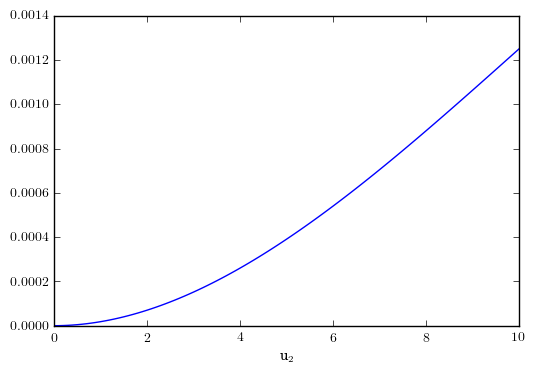

In [5]:
problem.solve()
problem.plot_u2(10)